In [4]:
from groundedPL.codificacion import ToPropositionalLogic
from groundedPL.logUtils import LogUtils
from groundedPL.tseitin import TseitinTransform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List, Dict, Optional, Tuple

In [5]:
# Definición de colores y casillas
colores = ['Amarillo', 'Azul', 'Rojo', 'Verde']
casillas = ['A','B','C','D','E','F','G','H','I']
casillas_ = [f'nodo{c}' for c in casillas]

In [6]:
# Parser para lógica proposicional
parser = ToPropositionalLogic()
parser.debug = False

In [7]:
# Definición de vecinos según tu especificación
vecinos = {
    'A': ['B','D','E','F'],
    'B': ['A','C','F','G'],
    'C': ['B','D','G','H'],
    'D': ['A','C','E','H'],
    'E': ['A','D','F','H','I'],
    'F': ['A','B','E','G','I'],
    'G': ['B','C','F','H','I'],
    'H': ['C','D','E','G','I'],
    'I': ['E','F','G','H'],
}

In [8]:
# Regla 1: cada casilla tiene al menos un color
def Regla1():
    listacasillas = []
    for k in casillas_:
        listacolores = []
        for c in colores:
            f = parser.to_nltk(f'ColorEnCasilla({c}, {k})')
            listacolores.append(f)
        ocasilla = LogUtils.Otoria(listacolores)
        listacasillas.append(ocasilla)
    return LogUtils.Ytoria(listacasillas)

In [9]:
# Regla 2: cada casilla tiene como máximo un color (exclusividad)
def Regla2():
    clausulas = []
    for k in casillas_:
        for i in range(len(colores)):
            for j in range(i+1, len(colores)):
                c1, c2 = colores[i], colores[j]
                f1 = parser.to_nltk(f'-ColorEnCasilla({c1}, {k})')
                f2 = parser.to_nltk(f'-ColorEnCasilla({c2}, {k})')
                clausulas.append(LogUtils.Otoria([f1, f2]))
    return LogUtils.Ytoria(clausulas)


In [10]:
# Regla 3: regiones vecinas no comparten color
def Regla3():
    clausulas = []
    for k, vecino in vecinos.items():
        for v in vecino:
            for c in colores:
                if k < v:
                    f1 = parser.to_nltk(f'-ColorEnCasilla({c}, nodo{k})')
                    f2 = parser.to_nltk(f'-ColorEnCasilla({c}, nodo{v})')
                    clausulas.append(LogUtils.Otoria([f1, f2]))
    return LogUtils.Ytoria(clausulas)

In [11]:
# Regla total
def ReglaTotal():
    return LogUtils.Ytoria([Regla1(), Regla2(), Regla3()])


In [12]:

def visualizar(I):
    # Inicializo el plano que contiene la figura
    fig, axes = plt.subplots(figsize=(8, 8))
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
    # Radio del círculo principal
    radius = 1.4
    # Radio del círculo medio
    mid_radius = 0.8
    # Radio del círculo interno
    inner_radius = 0.3
    
    # Diccionario de colores traducidos a inglés
    color_dict = {
        'Rojo': 'red',
        'Azul': 'cornflowerblue',
        'Amarillo': 'yellow',
        'Verde': 'green'
    }

    #Creacion de un diccionario vacio
    colores_asignados={}
    for casilla in casillas:
        for color in colores:
            formula=f'ColorEnCasilla({color}, nodo{casilla})' #se recorren todas las posibles formulas
            if I.get(formula): #si la formula se encuentra con un valor verdadero en el diccionario I...
                colores_asignados[casilla]=color #...la casilla se usa como llave para acceder al color en el diccionario
                break
      
  
    
    # Configuración de ángulos para las secciones externas e internas
    outer_angles = {
        'A': {'start': 315, 'end': 45},    # A en la parte superior-izquierda
        'B': {'start': 45, 'end': 135},    # B en la parte superior-derecha
        'C': {'start': 135, 'end': 225},   # C en la parte inferior-derecha
        'D': {'start': 225, 'end': 315}    # D en la parte inferior-izquierda
    }
    
    middle_angles = {
        'E': {'start': 270, 'end': 360},  # E toca A y D
        'F': {'start': 0, 'end': 90},     # F toca A y B
        'G': {'start': 90, 'end': 180},   # G toca B y C
        'H': {'start': 180, 'end': 270}   # H toca C y D
    }
    
    # Dibujar las secciones externas (A, B, C, D)
    for casilla, angles in outer_angles.items():
        
        esp_color = colores_asignados[casilla]     #se accede al color que corresponde a cada casilla usando el diccionario colores_asignados para acceder al color en español y color_dict para el equivalente en ingles             
        eng_color = color_dict[esp_color]
        
      
        # Crear el sector externo
        wedge = patches.Wedge(center=(0, 0), r=radius, theta1=angles['start'], theta2=angles['end'], 
                             facecolor=eng_color, edgecolor='black')
        axes.add_patch(wedge)
        
        # Añadir la etiqueta en el centro del sector
        start, end = angles['start'], angles['end']
        if end < start:
            end += 360
        angle_mid = (start + end) / 2
        angle_rad = np.radians(angle_mid % 360)
        x = radius * 0.85 * np.cos(angle_rad)
        y = radius * 0.85 * np.sin(angle_rad)
        axes.text(x, y, casilla, ha='center', va='center', fontweight='bold', fontsize=15, color='black')
    
    # Dibujar las secciones medias (E, F, G, H)
    for casilla, angles in middle_angles.items():
        esp_color = colores_asignados[casilla]                  
        eng_color = color_dict[esp_color]
        # Crear el sector medio
        wedge = patches.Wedge(center=(0, 0), r=mid_radius, theta1=angles['start'], theta2=angles['end'], 
                             facecolor=eng_color, edgecolor='black')
        axes.add_patch(wedge)
        
        # Añadir la etiqueta
        angle_rad = np.radians((angles['start'] + angles['end']) / 2)
        x = mid_radius * 0.55 * np.cos(angle_rad)
        y = mid_radius * 0.55 * np.sin(angle_rad)
        axes.text(x, y, casilla, ha='center', va='center', fontweight='bold', fontsize=15, color='black')
    
    # Dibujar la sección central (I)
    # Crear el círculo central para I
    esp_color_I= colores_asignados['I']
    color_I= color_dict[esp_color_I]
    center_circle = patches.Circle((0, 0), radius=inner_radius, facecolor=color_I, edgecolor='black')
    axes.add_patch(center_circle)
    
    # Añadir la etiqueta para I
    axes.text(0, 0, 'I', ha='center', va='center', fontweight='bold', fontsize=15, color='black')
    
    # Añadir leyenda para conflictos
    # Ajustar la relación de aspecto para un círculo perfecto
    axes.set_aspect('equal', 'box')
    
    # Configurar los límites de los ejes
    axes.set_xlim(-1.6, 1.6)
    axes.set_ylim(-1.6, 1.6)
    
    # Mostrar el gráfico
    plt.show()


In [13]:
# --- Algoritmo DPLL ---
# Helpers

def complemento(literal: str) -> str:
    if literal.startswith('-'):
        return literal[1:]
    else:
        return '-' + literal

In [14]:
def eliminar_literal(S: List[List[str]], l: str) -> List[List[str]]:
    S1 = [c for c in S if l not in c]
    cl = complemento(l)
    return [[p for p in c if p != cl] for c in S1]

In [15]:
def extender_I(I:Dict[str,bool], lit:str)->Dict[str,bool]:
    I1 = {key:value for key,value in I.items() if key != lit}
    if '-' in lit:
        I1[lit[-1]] = False
    else:
        I1[lit] = True
    return I1


In [16]:
def unit_propagate(S:List[List[str]], I:Dict[str,bool])->Tuple[List[List[str]],Dict[str,bool]]:
    while [] not in S:
        lit = ''
        for c in S:
            if len(c) == 1:
                lit = c[0]
                S = eliminar_literal(S, lit)
                I = extender_I(I, lit)
                break
        if lit == '':
            break
    return S, I

In [17]:
def DPLL(S: List[List[str]], I: Dict[str,bool]) -> Optional[Dict[str,bool]]:
    S, I = unit_propagate(S, I)
    if [] in S:
        return None
    if not S:
        return I
    # elegir primer literal
    for claus in S:
        for lit in claus:
            l=lit
            for lit in (l, complemento(l)):
                S1 = eliminar_literal(S, lit)
                I1 = extender_I(I, lit)
            r = DPLL(S1, I1)
            if r is not None:
                return r
    return None

In [62]:
# Función principal
def solucion_y_visualizar():
    # Construir la fórmula total y codificar a cadena
    F = ReglaTotal()
    codigo= parser.parse(F)
    # Tseitin a CNF
    cnf = TseitinTransform().tseitin(codigo)
    S = [list(c) for c in cnf]
    # Resolver
    modelo = DPLL(S, {})
     # Reconstruir I para visualización (con claves de tipo cadena)
    I = {}
    for casilla in casillas:
        for color in colores:
            formula = f'ColorEnCasilla({color}, nodo{casilla})'
            # modelo.keys() son códigos parseados, así que consultamos con parser.parse
            I[formula] = modelo.get(parser.parse(formula), False)
    # Visualizar
    visualizar(I)

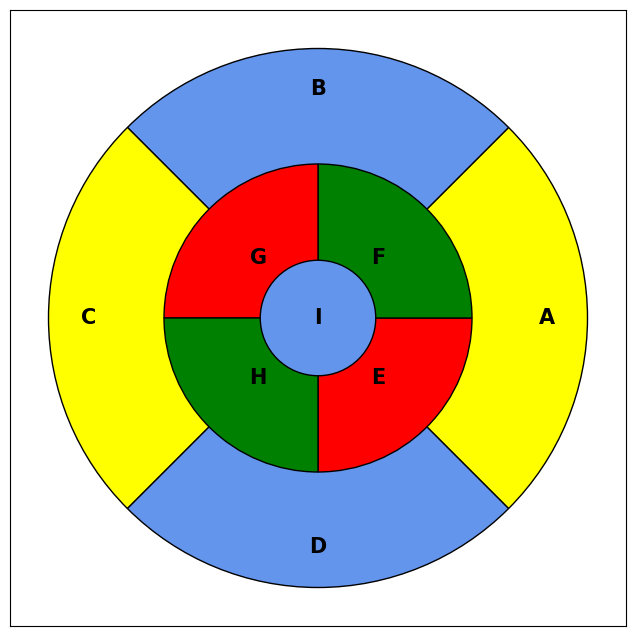

In [65]:
# Llamada final
solucion_y_visualizar()